# Pregel
Google Pregel ist ein verteiltes Rechenmodell für die Verarbeitung von Graphen. Basierend auf dem Bulk Synchronous Parallel Modell ist es geeignet, um auch große Graphen in verteilten Systemen zu analysieren.

In [ ]:
import math
import networkx as nx

from tui_dsmt.parallel import Pregel
from tui_dsmt.parallel.datasets import load_pregel_sp

## Inhaltsverzeichnis
- [Algorithmus](#Algorithmus)
- [Beispiel: Maximum](#Beispiel-Maximum)
- [Beispiel: Kürzester Pfad](#Beispiel-Kürzester-Pfad)
- [Zusammenfassung](#Zusammenfassung)

## Algorithmus
Pregel betrachtet jeden **gerichteten** Graphen als eine Abwandlung eines Automaten. Jeder Knoten in diesem Graphen muss dafür anhand seines Namens eindeutig identifizierbar sein und erhält zwei Zustände: Der erste Wert ist frei definierbar und wird für die Berechnung verwendet. Der zweite Wert beschreibt, ob dieser Knoten (noch) aktiv ist. Die gerichteten Kanten werden derweil ihrem Quellknoten zugeordnet und bekommen einen Zustand zugewiesen, der zur Weiterleitung von Informationen verwendet wird.

Pregel verläuft dann wie folgt:
1. Der Graph wird mit Hilfe einer Hash-Funktion partitioniert und in den verschiedenen Prozessen geladen.
2. Es werden wie beim BSP-Algorithmus Supersteps ausgeführt:
    1. Inaktive Knoten werden aktiviert, wenn eine neue Nachricht für sie im **letzten** Superstep eingetroffen ist.
    2. Für jeden **aktiven** Knoten wird eine Funktion aufgerufen. Ihre Eingabedaten bestehen aus dem aktuellen Wert des Knotens und der Werte der auf ihn verweisenden Kanten aus dem **letzten** Superstep.
    3. Die Funktion modifiziert den Wert des Knotens und kann beliebig viele Werte über die ausgehenden Kanten des Knotens senden. Außerdem kann die Funktion den Knoten deaktivieren.
3. Pregel endet, sobald alle Knoten deaktiviert sind.

Die Anlehnung an den BSP-Algorithmus ist durch die strikte Einteilung in Supersteps, die aus Berechnung, Kommunikation und Synchronisation bestehen, erkennbar:

Der Berechnungsschritt besteht aus der Anwendung der gegebenen Funktion. Sie hängt ausschließlich vom aktuellen Wert des Knotens und den empfangenen Nachrichten ab. Diese liegen nach Beendigung des vorangegangenen Supersteps vollständig lokal vor, sodass die Ausführung dieser Funktion voll parallel erfolgen kann.

Die Kommunikationsphase besteht aus der Weiterleitung der Kantenwerte an benachbarte Knoten. Durch diesen Ansatz lassen sich Situationen vermeiden, in denen während der Berechnung Daten von anderen Knoten aktiv angefordert und damit weitere Latenz in den Berechnungsschritt eingeführt wird. Ebenfalls hervorzuheben ist der Einfluss der Hash-Funktion: Die Autoren schlagen für eine feste Anzahl an Partitionen $N$ die denkbar einfache Funktion $hash(\text{Name}) % N$ vor. Da sie ausschließlich vom Identifier des Knoten abhängt, lässt sich das Ziel einer Nachricht während der Kommunikationsphase vollständig dezentral und parallel berechnen, sodass kein globaler Index über die Position der Knoten in den verschiedenen Prozessen vorgehalten werden muss. (Um bei bekannter Struktur des Graphen die Lokalität zu erhöhen, können natürlich auch komplexere Funktionen verwendet werden.)

Theoretisch kann die Funktion auch die Topologie des Graphen ändern. Das ist für die meisten Graphalgorithmen allerdings nicht notwendig.

## Beispiel: Maximum
Im nachfolgenden Beispiel soll das Maximum aller Knotenwerte über den Graphen verteilt werden.

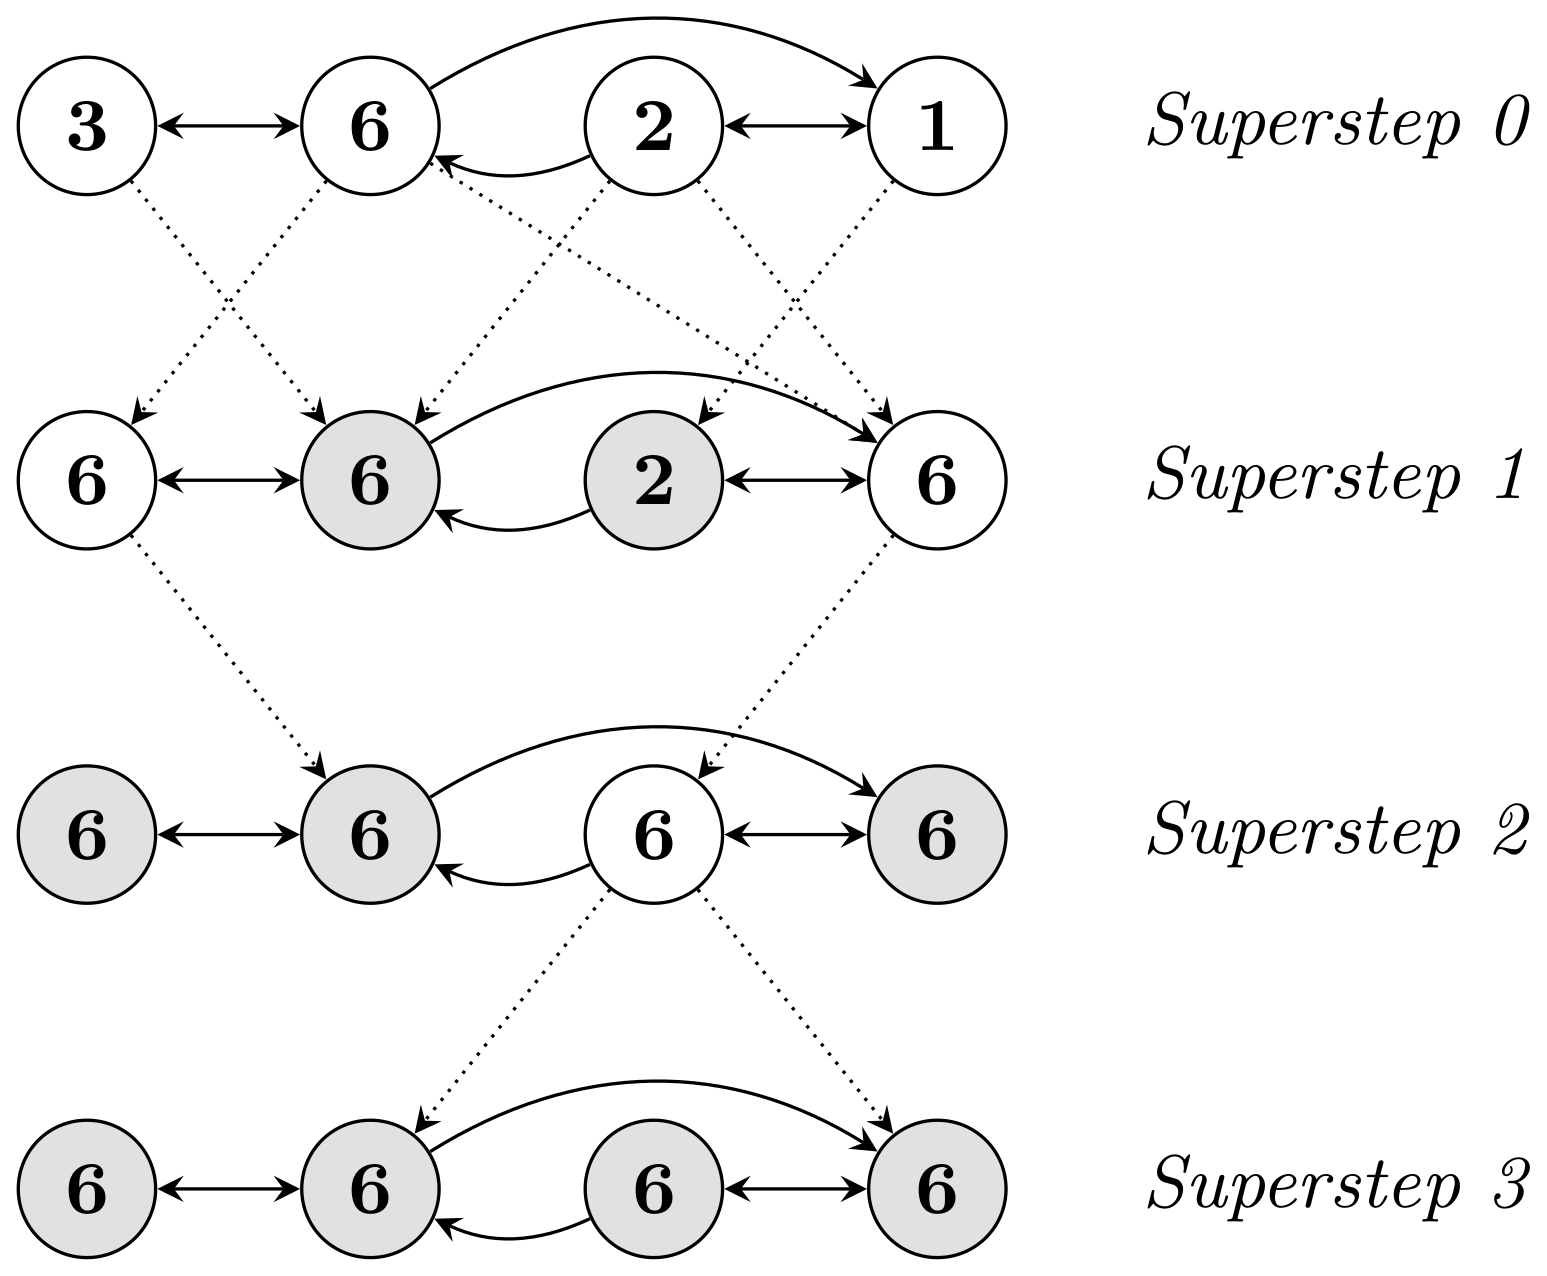 <br>
Bildquelle: Malewicz et al., 2010 @ Google Inc.

Im $0.$ Superstep werden die Knoten geladen und partitioniert. (Hier wird zum Verständnis auf die Partitionen verzichtet.) Ihr aktueller Wert wird außerdem auf die ausgehenden Kanten geschrieben.

Im $1.$ Superstep bildet jeder Knoten das Maximum des eigenen und aller eingehenden Werte. Entspricht das Maximum dem aktuellen Wert, wird der Knoten deaktiviert. Andernfalls wird das Maximum als neuer Wert übernommen und außerdem auf die ausgehenden Kanten geschrieben.

Im $2.$ Superstep ist zu erkennen, dass bereits nur noch ein Teil der Nachrichten verschickt wird, da von den deaktivierten Knoten keine neue Information ausgeht. Außerdem ist zu sehen, wie der dritte Knoten durch den Empfang einer Nachricht reaktiviert wird.

Im $3.$ Superstep werden auch die verbleibenden Knoten deaktiviert. Dementsprechend endet der Algorithmus. Die Information des maximalen Knotenwerts ist bei allen Knoten im Graph angekommen.

## Beispiel: Kürzester Pfad
Das folgende Beispiel zeigt die Berechnung des kürzesten Pfades in einem Beispielgraph. Zur Reduktion der Komplexität wird ein interaktives, aber vereinfachtes Modell des Pregel-Algorithmus verwendet, das Einschränkungen besitzt:
- Die verwendete Funktion hat selbst keinen Zugriff auf die Nachbarn.
- Das Ergebnis aktiver Knoten wird automatisch an alle Nachbarn geschickt.
- Für jeden Knoten steht ein lokaler Speicher für Zwischenergebnisse bereit, die nicht versendet werden müssen. Dieser wird aber nicht mit anderen Knoten geteilt, selbst wenn sie der selben Partition zugeordnet werden.

Es reicht dennoch aus, um viele Graphalgorithmen abzubilden. Im Folgenden soll ein kürzester Pfad zu jeweils allen anderen Knoten entdeckt werden. Dazu wird ausgehend von $A$ der Abstand von $A$ jeweils zu allen Nachbarn gesendet. Die Nachbarn speichern den kürzesten Abstand zu $A$ und den Nachbarn, über den dieser Abstand möglich ist, und senden ihn weiter, sodass sich diese Information im Graph ausbreitet.

Die Implementierung der Funktion selbst ist simpel, da die Partitionierung (farbige Umrandung) und Kommunikation von Pregel erledigt wird. Aktivierte Knoten werden dabei blau dargestellt, während deaktivierte grau hinterlegt sind.

In [ ]:
# Laden des Graphen
graph, pos = load_pregel_sp()

# Initialisierungsfunktion für Knoten
def node_init(node):
    return (-1 if node == 'A' else math.inf, None)

# Vorbereiten der Pregel Funktion
def pregel_fun(current_value, received_from, received_values, local_storage):
    # falls Werte empfangen wurden
    if len(received_values) > 0:
        # aktueller Wert des Knotens
        c_value, c_from = current_value

        # Minimum der empfangenen Werte
        # (um 1 erhöht wegen Verstand über Kante)
        min_recv, min_from = min((v+1, f) for f, (v, _) in zip(received_from, received_values))

        # Falls der empfangene Wert kleiner als der
        # aktuell gespeicherte ist, wird der Wert
        # des aktuellen Knotens aktualisiert, indem
        # das neue Minimum zusammen mit dem Sender
        # gepsichert wird. Der Knoten bleibt aktiv.
        if min_recv < c_value:
            return (min_recv, min_from), True

    # Als Standardfall bleibt der Wert
    # unverändert und der Knoten wird
    # deaktiviert.
    return current_value, False

# Aufruf der Animation
Pregel(graph, node_init, pregel_fun, pos,
       partition_hash_fun=lambda node: ord(node) % 3,
       print_messages=True)

In Superstep $0$ erhält $A$ als einziger Knoten einen neuen Wert mit dem Abstand $0$ und keinem Ursprung. Alle anderen Knoten werden deaktiviert. Die Information von $A$ wird an $B$ und $C$ weitergeleitet, womit diese wieder aktiviert werden.

In Superstep $1$ speichern beide den Abstand $1$ und den Ursprung $A$ und senden diese Information an $D$ und $F$.

In Superstep $2$ wird genau so verfahren und $E$ und $G$ erreicht.

In Superstep $3$ wird ist hervorzuheben, dass $E$ die Information erneut an $F$ und $G$ sendet. In Superstep $4$ führen aber weder $F$ noch $G$ ein Update durch, da der gespeicherte Wert kleiner ist, und deaktivieren sich wieder, womit der Algorithmus endet.

Hervorzuheben ist außerdem, dass $H$ nicht erreicht wird, deshalb bis auf den ersten Superstep durchgängig deaktiviert ist und keine Rechenleistung benötigt.

Der kürzeste Pfad von $A$ zu einem anderen Knoten lässt sich nun ableiten, indem der Pfad anhand der gespeicherten Information rückwärts verfolgt wird, also beispielsweise $G \rightarrow F \rightarrow C \rightarrow A$. Da der Abstand für $H$ bei $inf$ blieb, lässt sich ableiten, dass $H$ nicht von $A$ erreichbar ist.

## Zusammenfassung
Pregel ist ein Framework zur effizienten Berechnung von Graphalgorithmen in verteilten Systeme, basierend auf dem BSP-Modell. Der offensichtlichste Vorteil ist dabei die einfache Implementierung eigener Funktionen, da sich nicht um die Kommunikation gekümmert werden muss.